In [2]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Exploring and Cleaning AQS Sensor Data

In [4]:
aqs = pd.read_csv('data/aqs_06-067-0010.csv')
aqs

,state_code,county_code,site_number,parameter_code,...,city,cbsa_code,cbsa,date_of_last_change
0,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
1,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
2,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
...,...,...,...,...,...,...,...,...,...
2265,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
2266,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24
2267,6,67,10,88101,...,Sacramento,40900,"Sacramento--Roseville--Arden-Arcade, CA",2021-09-24


(introduce display_df)

In [25]:
display_df(aqs.iloc[0].to_frame(), rows=31)

,0
state_code,6
county_code,67
site_number,10
parameter_code,88101
poc,1
latitude,38.57
longitude,-121.49
datum,NAD83
parameter,PM2.5 - Local Conditions
sample_duration,24 HOUR


Data dictionary: https://aqs.epa.gov/aqsweb/airdata/FileFormats.html#_daily_summary_files

questions:

1. what's granularity of data?
1. what columns do we want to keep?
1. what do we do about missing data?
1. can we see any patterns in the PM2.5 in this dataset?

In [7]:
aqs[['date_local', 'validity_indicator', 'arithmetic_mean', 'aqi']]

,date_local,validity_indicator,arithmetic_mean,aqi
0,2018-12-31,Y,3.1,13
1,2018-12-31,Y,3.1,13
2,2018-12-28,Y,1.0,4
...,...,...,...,...
2265,2019-01-06,Y,5.3,22
2266,2019-01-03,Y,31.1,91
2267,2019-01-03,Y,31.1,91


Why are there multiple readings per date?

In [8]:
def has_diff_data(series):
    return len(series.unique()) > 1

cols = (aqs
 .groupby('date_local')
 .agg(has_diff_data)
 .any('rows')
)
cols[cols]


pollutant_standard    True
event_type            True
dtype: bool

In [9]:
aqs[['date_local', 'pollutant_standard', 'event_type', 'validity_indicator', 'arithmetic_mean', 'aqi']]

,date_local,pollutant_standard,event_type,validity_indicator,arithmetic_mean,aqi
0,2018-12-31,PM25 24-hour 2006,None,Y,3.1,13
1,2018-12-31,PM25 24-hour 2006,Included,Y,3.1,13
2,2018-12-28,PM25 24-hour 2006,None,Y,1.0,4
...,...,...,...,...,...,...
2265,2019-01-06,PM25 Annual 1997,Included,Y,5.3,22
2266,2019-01-03,PM25 Annual 1997,None,Y,31.1,91
2267,2019-01-03,PM25 Annual 1997,Included,Y,31.1,91


But do these result in different PM2.5 measurements?

In [10]:
(aqs.groupby('date_local')
 [['arithmetic_mean']]
 .agg(has_diff_data)
 .query('arithmetic_mean == True')
)

,arithmetic_mean
date_local,


Nope, so we can just take the first observation for each date.

In [11]:
aqs_clean = (aqs.groupby('date_local')
 .first()
 [['arithmetic_mean', 'aqi']]
 .rename(columns={'arithmetic_mean': 'pm25'})
 .reset_index()
)
aqs_clean

,date_local,pm25,aqi
0,2018-05-20,6.5,27
1,2018-05-23,2.3,10
2,2018-05-29,11.8,49
...,...,...,...
186,2019-12-23,5.7,24
187,2019-12-26,2.0,8
188,2019-12-29,19.5,67


(checking against cleaned data)

In [13]:
clean = (pd.read_csv('data/cleaned_purpleair_aqs/Full24hrdataset.csv')
         [['Date', 'ID', 'PM25FM']]
        )
ca1_clean = (clean
 .query('ID == "CA1"')
 .sort_values('Date')
)
ca1_clean

,Date,ID,PM25FM
1776,2018-05-20,CA1,6.5
1777,2018-05-23,CA1,2.3
1778,2018-05-29,CA1,11.8
...,...,...,...
1731,2019-12-23,CA1,5.7
1732,2019-12-26,CA1,2.0
1733,2019-12-29,CA1,19.5


(why are there less rows? likely because purpleair didn't have valid sensor values for those days)

the importance of pandas data types:

In [14]:
aqs_clean

,date_local,pm25,aqi
0,2018-05-20,6.5,27
1,2018-05-23,2.3,10
2,2018-05-29,11.8,49
...,...,...,...
186,2019-12-23,5.7,24
187,2019-12-26,2.0,8
188,2019-12-29,19.5,67


<AxesSubplot:xlabel='date_local'>

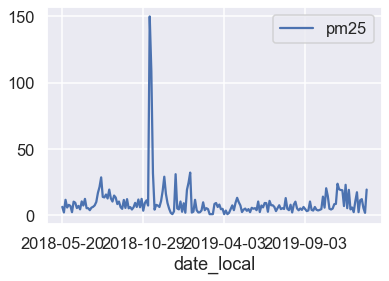

In [15]:
aqs_clean.plot('date_local', 'pm25')

In [16]:
aqs_clean = aqs_clean.assign(date=pd.to_datetime(aqs_clean['date_local']))
aqs_clean

,date_local,pm25,aqi,date
0,2018-05-20,6.5,27,2018-05-20
1,2018-05-23,2.3,10,2018-05-23
2,2018-05-29,11.8,49,2018-05-29
...,...,...,...,...
186,2019-12-23,5.7,24,2019-12-23
187,2019-12-26,2.0,8,2019-12-26
188,2019-12-29,19.5,67,2019-12-29


<AxesSubplot:xlabel='date'>

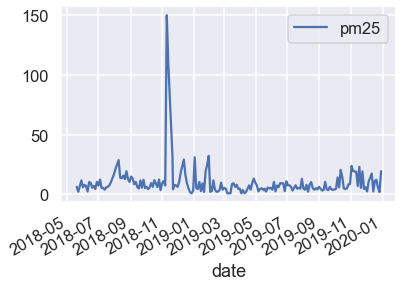

In [17]:
aqs_clean.plot('date', 'pm25')

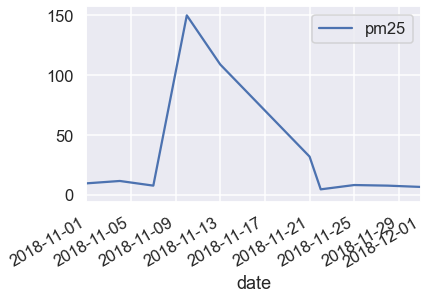

In [18]:
aqs_clean.plot('date', 'pm25')
plt.xlim(('2018-11-01', '2018-12-01'));

What happened in Nov 2018?

https://www.wikiwand.com/en/Camp_Fire_(2018)

The Camp Fire was the deadliest and most destructive wildfire in California's history,[11] and the most expensive natural disaster in the world in 2018 in terms of insured losses.[12][13][3]

Named after Camp Creek Road, its place of origin,[14] the fire started on Thursday, November 8, 2018, in Northern California's Butte County. Ignited by a faulty electric transmission line, the fire originated above several communities and an east wind drove the fire downhill through developed areas. After exhibiting extreme fire spread, fireline intensity, and spotting behaviors through the rural community of Concow, an urban firestorm formed in the foothill town of Paradise.[15][16][17][18] Drought was a factor: Paradise, which typically sees five inches of autumn rain by November 12, had only received one-seventh of an inch by that date in 2018. With the arrival of the first winter rainstorm of the season, the fire reached 100 percent containment after seventeen days on November 25.